
# 📊 Análise Exploratória - Ofertas Relâmpago - Desafio Técnico

- Nome: Thiago Augusto Santos Lima

Este estudo analisa resultados de ofertas do tipo relâmpago realizadas em um período e país específicos, buscando entender quais fatores mais influenciam o desempenho das promoções.
Formas de avaliar os resultados:
- Número de vendas – volume total de itens vendidos.
- Aproveitamento de estoque – proporção vendida em relação ao estoque disponível.
- Receita gerada – valor total obtido com as vendas.

Hipóteses analisadas:
- O frete grátis aumenta o volume de vendas?
- O horário de início da promoção impacta o resultado?
- Promoções com mais tempo no ar geram mais vendas?
- O desempenho varia de acordo com a vertical do produto?


### Importação das Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway, kruskal
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

### Importação dos dados

In [2]:
df = pd.read_csv("datasets/ofertas_relampago.csv")

### Validação e Tratamento de Dados

Primeiro vamos garantir que estamos tratando os tipos das variáveis corretamente. E ter uma visão geral delas.

In [3]:
date_cols = ["OFFER_START_DATE", "OFFER_START_DTTM", "OFFER_FINISH_DTTM"]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

num_cols = ["INVOLVED_STOCK", "REMAINING_STOCK_AFTER_END", "SOLD_AMOUNT", "SOLD_QUANTITY"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

df["ORIGIN"] = df["ORIGIN"].replace("NA", np.nan)
df["SHIPPING_PAYMENT_TYPE"] = df["SHIPPING_PAYMENT_TYPE"].replace(to_replace=["none", "None", "NONE"], value=np.nan)

from skimpy import skim
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 48746  │ │ string      │ 6     │                                                          │
│ │ Number of columns │ 13     │ │ datetime64  │ 3     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 2     │                                                          │
│                                │ float64     │ 2     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━━┓  │
│ ┃ column            ┃ NA    ┃ NA %             ┃ mean  ┃ sd    ┃ p0   ┃ p25  ┃ p50   ┃ p75   ┃ p100 ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━━┩  │
│ │ INVOLVED_STOCK    │     0 │                0 │ 35.01 │ 206.8 │    1 │    5 │    10 │    15 │ 9000 │   █    │  │
│ │ REMAINING_STOCK_A │     0 │                0 │ 30.57 │ 195.8 │ -192 │    4 │     8 │    15 │ 8635 │   █    │  │
│ │ FTER_END          │       │                  │       │       │      │      │       │       │      │        │  │
│ │ SOLD_AMOUNT       │ 24167 │ 49.5774012226644 │ 51.21 │ 175.3 │ 0.28 │ 5.73 │ 12.42 │ 30.93 │ 4837 │   █    │  │
│ │                   │       │                2 │       │       │      │      │       │       │      │        │  │
│ │ SOLD_QUANTITY     │ 24167 │ 49.5774012226644 │ 10.85 │ 45.48 │    1 │    1 │     3 │     6 │ 1646 │   █    │  │
│ │                   │       │                2 │       │       │      │      │       │       │      │        │  │
│ └───────────────────┴───────┴──────────────────┴───────┴───────┴──────┴──────┴───────┴───────┴──────┴────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓  │
│ ┃ column                 ┃ NA   ┃ NA %   ┃ first                    ┃ last                     ┃ frequency   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩  │
│ │ OFFER_START_DATE       │    0 │      0 │        2021-06-01        │        2021-07-31        │ None        │  │
│ │ OFFER_START_DTTM       │    0 │      0 │   2021-06-01 07:00:00    │   2021-07-31 19:00:00    │ None        │  │
│ │ OFFER_FINISH_DTTM      │    0 │      0 │   2021-06-01 07:00:00    │   2021-08-01 03:00:00    │ None        │  │
│ └────────────────────────┴──────┴────────┴──────────────────────────┴──────────────────────────┴─────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃          ┃       ┃          ┃          ┃          ┃          ┃           ┃ chars    ┃ words per ┃ total    ┃  │
│ ┃ column   ┃ NA    ┃ NA %     ┃ shortest ┃ longest  ┃ min      ┃ max       ┃ per row  ┃ row       ┃ words    ┃  │
│ ┡━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━

### Relação Vendas e Estoques

Foi criada a variável Vendas Calculadas com o objetivo de entender o comportamento de estoque e validar os processos gerais. Nesse contexto, vendas calculadas deveria ser equivalente ao SOLD_QUANTITY, porém não é o que acontece.

In [4]:
df['VENDAS_CALCULADAS'] = df['INVOLVED_STOCK'] - df['REMAINING_STOCK_AFTER_END']

df_erro_vendas = df[df['SOLD_QUANTITY'].notna() & (df['SOLD_QUANTITY'] != df['VENDAS_CALCULADAS'])]
print(f"Quantidade de promoções onde 'Vendas != Estoque - Estoque_after': {len(df_erro_vendas)}")
display(df_erro_vendas)

Quantidade de promoções onde 'Vendas != Estoque - Estoque_after': 2995


,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID,VENDAS_CALCULADAS
33,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 19:00:00+00:00,lightning_deal,15,11,26.82,5.0,NaN,free_shipping,APPAREL,APP & SPORTS,MLM-BLOUSES,4
37,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 21:00:00+00:00,lightning_deal,10,8,13.34,3.0,A,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-MUGS,2
93,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-23 01:00:09+00:00,lightning_deal,10,9,13.58,2.0,NaN,free_shipping,PETS FOOD,CPG,MLM-CATS_AND_DOGS_FOODS,1
99,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 19:28:55+00:00,lightning_deal,7,-3,15.57,6.0,A,free_shipping,PETS FOOD,CPG,MLM-CATS_AND_DOGS_FOODS,10
153,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-23 01:00:03+00:00,lightning_deal,5,3,24.99,3.0,NaN,free_shipping,FOOTWEAR,APP & SPORTS,MLM-SANDALS_AND_FLIP_FLOPS,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48489,2021-06-19,2021-06-19 10:00:00+00:00,2021-06-19 18:00:00+00:00,lightning_deal,30,26,90.40,1.0,A,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-FRAME_POOLS,4
48490,2021-06-19,2021-06-19 10:00:00+00:00,2021-06-19 18:00:00+00:00,lightning_deal,30,26,271.20,3.0,A,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-FRAME_POOLS,4
48570,2021-06-19,2021-06-19 19:00:00+00:00,2021-06-20 01:00:05+00:00,lightning_deal,5,5,5.21,4.0,NaN,NaN,SPORTS,APP & SPORTS,MLM-KINESIOLOGY_TAPES,0
48628,2021-06-19,2021-06-19 15:00:00+00:00,2021-06-19 23:00:00+00:00,lightning_deal,30,27,9.61,4.0,A,NaN,TOOLS AND CONSTRUCTION,HOME & INDUSTRY,MLM-ANGLE_FINDERS,3


Além disso, temos outro problema. Estoque pós venda negativo. Isso ocorre porque vendeu a mais do que tinha no estoque reservado. Como não temos como garantir que existe ainda itens em outro tipo de estoque, essas vendas a mais devem ser desconsideradas.

### Ofertas com estoque negativo

Promoções com estoque após final negativo por VERTICAL:


VERTICAL
HOME & INDUSTRY    343
BEAUTY & HEALTH    297
APP & SPORTS       215
CE                 185
CPG                107
ACC                 87
T & B               36
OTHERS               3
dtype: int64

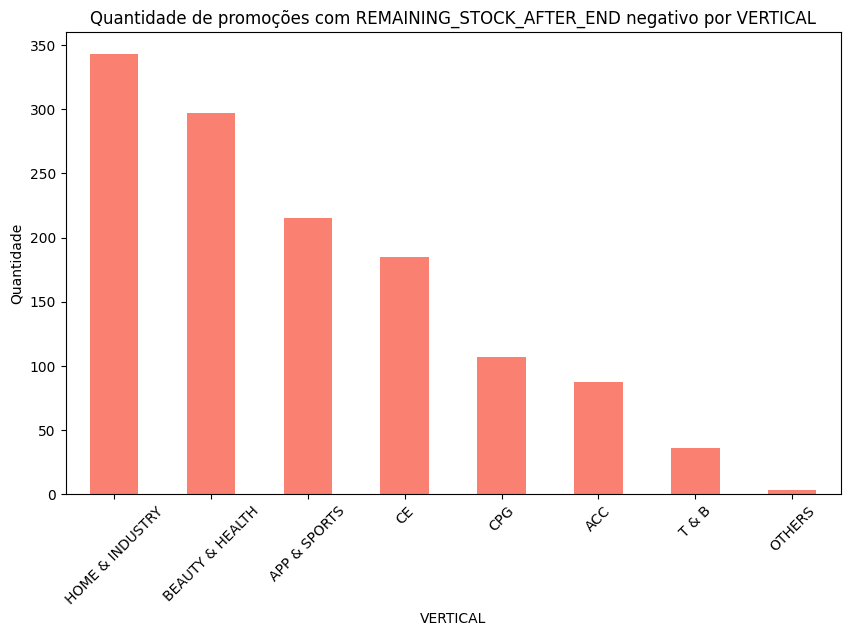

In [5]:
df_estoque_neg = df[df['REMAINING_STOCK_AFTER_END'] < 0]
tabela_estoque_neg = df_estoque_neg.groupby('VERTICAL').size().sort_values(ascending=False)
print("Promoções com estoque após final negativo por VERTICAL:")
display(tabela_estoque_neg)

plt.figure(figsize=(10,6))
tabela_estoque_neg.plot(kind='bar', color='salmon')

plt.title("Quantidade de promoções com REMAINING_STOCK_AFTER_END negativo por VERTICAL")
plt.ylabel("Quantidade")
plt.xlabel("VERTICAL")
plt.xticks(rotation=45)
plt.show()

Com a hipótese que isso possa ter ocorrido em áreas específicas, foi avaliado o % em cada vertical em que isso acontece.

In [6]:
total_por_vertical = df.groupby('VERTICAL').size()
negativos_por_vertical = df_estoque_neg.groupby('VERTICAL').size()
tabela_percentual = pd.DataFrame({ 'total_promos': total_por_vertical, 'promos_estoque_negativo': negativos_por_vertical }).fillna(0)
tabela_percentual['percentual_negativo'] = tabela_percentual['promos_estoque_negativo'] / tabela_percentual['total_promos']
tabela_percentual = tabela_percentual.sort_values(by='percentual_negativo', ascending=False)
print("Percentual de promoções com REMAINING_STOCK_AFTER_END negativo por VERTICAL:")
display(tabela_percentual)

Percentual de promoções com REMAINING_STOCK_AFTER_END negativo por VERTICAL:


,total_promos,promos_estoque_negativo,percentual_negativo
VERTICAL,,,
BEAUTY & HEALTH,7150,297.0,0.041538
CPG,2714,107.0,0.039425
ACC,2573,87.0,0.033813
HOME & INDUSTRY,11011,343.0,0.031151
CE,8629,185.0,0.021439
APP & SPORTS,13241,215.0,0.016237
T & B,2624,36.0,0.013720
OTHERS,279,3.0,0.010753
ENTERTAINMENT,525,0.0,0.000000


Outro caso muito importante encontrado é a presença de promoções com menos de 1 minuto de duração e que não geraram nenhuma venda. Como não temos garantia de que de fato essas promoções ocorreram, elas foram desconsideradas das nossas análises.

### Promoções com duração menor que 1 minuto

In [ ]:
df['DURACAO_HORAS'] = (df['OFFER_FINISH_DTTM'] - df['OFFER_START_DTTM']).dt.total_seconds() / 3600

promo_menos_1min = df[df['DURACAO_HORAS'] < (1/60)]
qtd_menos_1min = len(promo_menos_1min)
total_promos = len(df)
proporcao = qtd_menos_1min / total_promos * 100
print(f"Promoções com duração < 1 minuto: {qtd_menos_1min} ({proporcao:.2f}%)")

Promoções com duração < 1 minuto: 3814 (7.82%)


Agora, visto que temos essas promoções com menos de 1 minuto e que as informações de vendas do SOLD_QUANTITY não são 100% corretas, foram realizados algumas exclusões e alguns tratamentos. Dentre o tratamento, temos:
- Todas as vendas serão consideradas baseadas nas movimentações de estoque.
- Após a correção das vendas, o SOLD_AMOUNT também foi corrigido, usando o valor de ticket_médio.
- Ofertas que geraram estoques pós negativos, foram corrigidos, gerando assim apenas as vendas possíveis.

In [8]:
df = df[df['DURACAO_HORAS'] >= (1/60)]

df['VALOR_UNITARIO'] = df['SOLD_AMOUNT'] / df['SOLD_QUANTITY']
mask_corrigir = df['SOLD_AMOUNT'].isna() & (df['VENDAS_CALCULADAS'] > 0)
df.loc[mask_corrigir, 'SOLD_AMOUNT'] = df.loc[mask_corrigir, 'VENDAS_CALCULADAS'] * df.loc[mask_corrigir, 'VALOR_UNITARIO']

mask_estoque_neg = df['REMAINING_STOCK_AFTER_END'] < 0
df.loc[mask_estoque_neg, 'SOLD_QUANTITY'] = df.loc[mask_estoque_neg, 'VENDAS_CALCULADAS'] + df.loc[mask_estoque_neg, 'REMAINING_STOCK_AFTER_END']
df.loc[mask_estoque_neg, 'REMAINING_STOCK_AFTER_END'] = 0

### Valores Faltantes

Notou-se valores faltantes, principalmente em relação a informações de SOLD_AMOUNT E SOLD_QUANTITY.

In [9]:
total_promos = len(df)
qtd_sold_amount_nan = df['SOLD_AMOUNT'].isna().sum()
perc_sold_amount_nan = (qtd_sold_amount_nan / total_promos) * 100
qtd_sold_quantity_nan = df['SOLD_QUANTITY'].isna().sum()
perc_sold_quantity_nan = (qtd_sold_quantity_nan / total_promos) * 100
print(f"Promoções sem SOLD_AMOUNT: {qtd_sold_amount_nan} ({perc_sold_amount_nan:.2f}%)")
print(f"Promoções sem SOLD_QUANTITY: {qtd_sold_quantity_nan} ({perc_sold_quantity_nan:.2f}%)")

Promoções sem SOLD_AMOUNT: 20353 (45.30%)
Promoções sem SOLD_QUANTITY: 20321 (45.23%)


In [10]:
# Total de promoções com SOLD_AMOUNT ausente
total_sold_amount_nan = df['SOLD_AMOUNT'].isna().sum()

# Promoções sem SOLD_AMOUNT mas com vendas calculadas > 0
df_sem_valor_mais_vendas = df[(df['SOLD_AMOUNT'].isna()) & (df['VENDAS_CALCULADAS'] > 0)]
qtd_sem_valor_mais_vendas = len(df_sem_valor_mais_vendas)

# Calcular porcentagem em relação ao total de SOLD_AMOUNT ausente
perc_sem_valor_mais_vendas = (qtd_sem_valor_mais_vendas / total_sold_amount_nan) * 100 if total_sold_amount_nan > 0 else 0

print(f"Promoções sem SOLD_AMOUNT: {total_sold_amount_nan}")
print(f"Dessas, promoções com vendas > 0: {qtd_sem_valor_mais_vendas} ({perc_sem_valor_mais_vendas:.2f}%)")


Promoções sem SOLD_AMOUNT: 20353
Dessas, promoções com vendas > 0: 588 (2.89%)


## Análises Visão Geral

In [11]:
# Visão geral (total)
visao_geral = pd.DataFrame({
    'ofertas_realizadas': [len(df)], 
    'total_vendas': [df['SOLD_QUANTITY'].sum()],
    'total_receita': [df['SOLD_AMOUNT'].sum()],
    'total_estoque': [df['INVOLVED_STOCK'].sum()]
})
visao_geral['aproveitamento_estoque'] = visao_geral['total_vendas'] / visao_geral['total_estoque']
print("\nVisão geral:")
display(visao_geral)





Visão geral:


,ofertas_realizadas,total_vendas,total_receita,total_estoque,aproveitamento_estoque
0,44932,264051.0,1258663.5,1641073,0.160901


In [12]:
metricas_vertical = df.groupby('VERTICAL').agg(
    ofertas_realizadas=('VERTICAL', 'size'),  # quantidade de linhas por vertical
    total_vendas=('SOLD_QUANTITY', 'sum'),
    total_receita=('SOLD_AMOUNT', 'sum'),
    total_estoque=('INVOLVED_STOCK', 'sum')
).reset_index()
metricas_vertical['aproveitamento_estoque'] = metricas_vertical['total_vendas'] / metricas_vertical['total_estoque']
print("\nVisão por VERTICAL:")
display(metricas_vertical)


Visão por VERTICAL:


,VERTICAL,ofertas_realizadas,total_vendas,total_receita,total_estoque,aproveitamento_estoque
0,ACC,2358,4981.0,26819.98,22277,0.223594
1,APP & SPORTS,12322,25146.0,131101.36,222608,0.112961
2,BEAUTY & HEALTH,6552,177396.0,547427.27,890289,0.199257
3,CE,7850,21608.0,362787.94,201675,0.107143
4,CPG,2455,5475.0,16787.68,37278,0.146869
5,ENTERTAINMENT,479,357.0,1988.57,2784,0.128233
6,HOME & INDUSTRY,10250,26530.0,155518.68,220667,0.120226
7,OTHERS,240,354.0,1929.24,2389,0.148179
8,T & B,2426,2204.0,14302.78,41106,0.053617


/var/folders/rh/gjnf3wr53k74t6c597cx8_wm0000gn/T/ipykernel_57822/1238930396.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VERTICAL', y='ofertas_realizadas', data=metricas_vertical, palette='Blues_d')


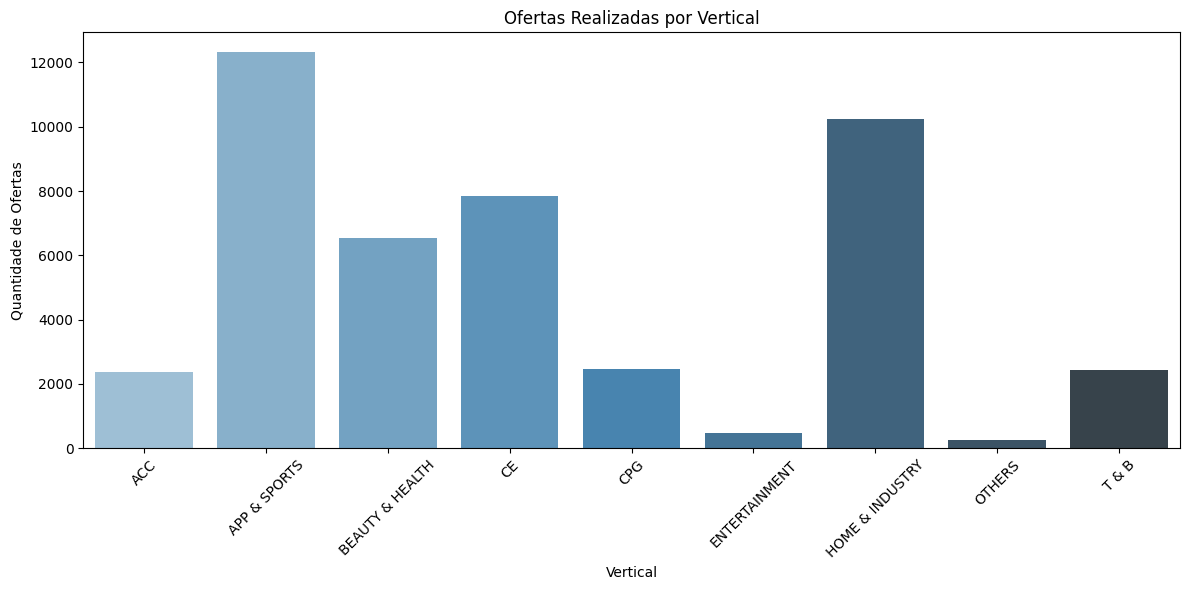

/var/folders/rh/gjnf3wr53k74t6c597cx8_wm0000gn/T/ipykernel_57822/1238930396.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VERTICAL', y='total_vendas', data=metricas_vertical, palette='Greens_d')


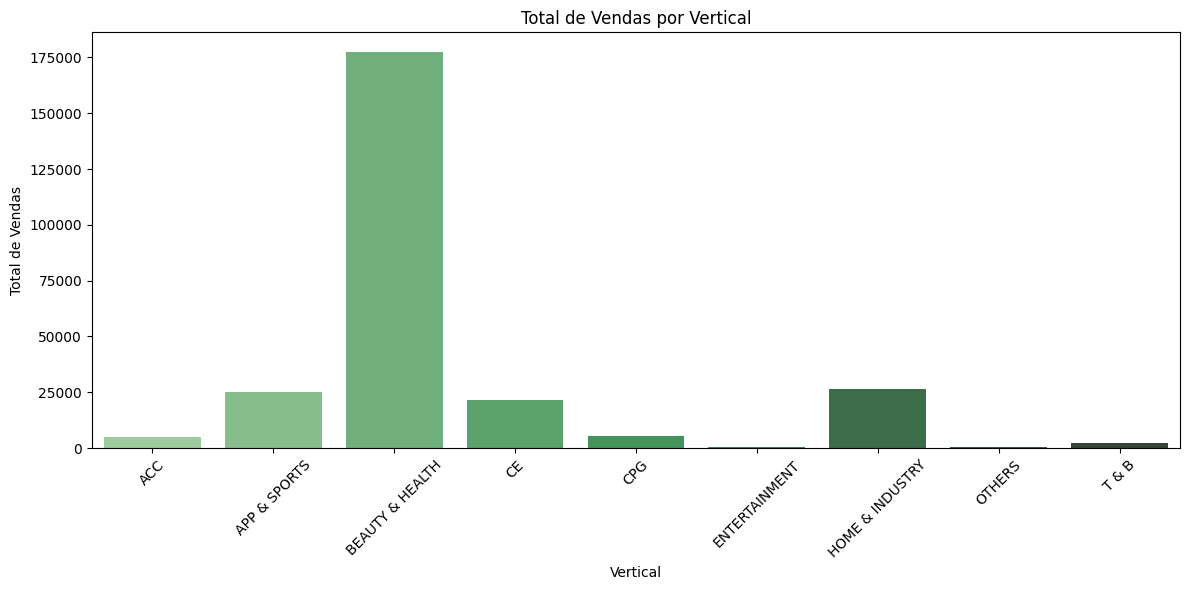

/var/folders/rh/gjnf3wr53k74t6c597cx8_wm0000gn/T/ipykernel_57822/1238930396.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VERTICAL', y='total_receita', data=metricas_vertical, palette='Oranges_d')


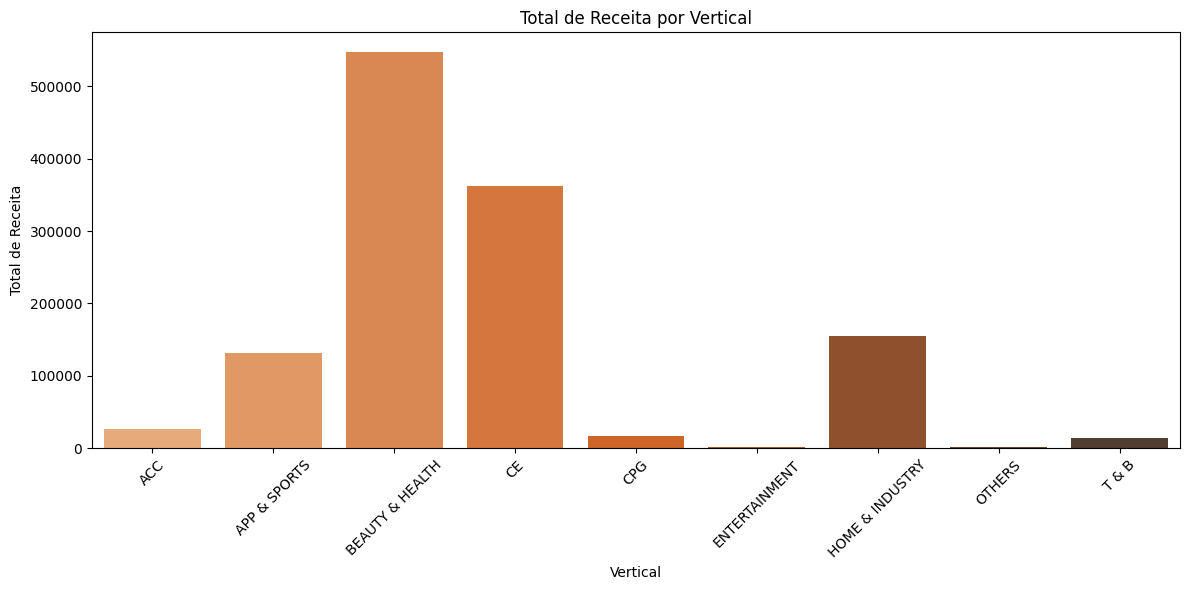

/var/folders/rh/gjnf3wr53k74t6c597cx8_wm0000gn/T/ipykernel_57822/1238930396.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VERTICAL', y='aproveitamento_estoque', data=metricas_vertical, palette='Purples_d')


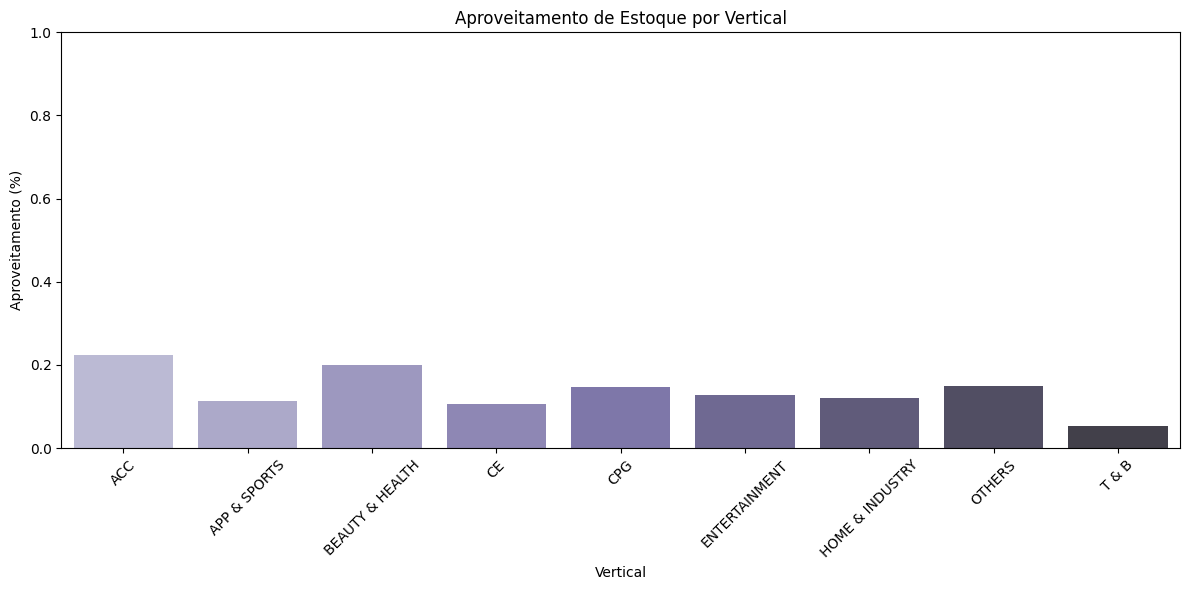

In [13]:
plt.figure(figsize=(12,6))
sns.barplot(x='VERTICAL', y='ofertas_realizadas', data=metricas_vertical, palette='Blues_d')
plt.title('Ofertas Realizadas por Vertical')
plt.ylabel('Quantidade de Ofertas')
plt.xlabel('Vertical')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(x='VERTICAL', y='total_vendas', data=metricas_vertical, palette='Greens_d')
plt.title('Total de Vendas por Vertical')
plt.ylabel('Total de Vendas')
plt.xlabel('Vertical')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(x='VERTICAL', y='total_receita', data=metricas_vertical, palette='Oranges_d')
plt.title('Total de Receita por Vertical')
plt.ylabel('Total de Receita')
plt.xlabel('Vertical')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(x='VERTICAL', y='aproveitamento_estoque', data=metricas_vertical, palette='Purples_d')
plt.title('Aproveitamento de Estoque por Vertical')
plt.ylabel('Aproveitamento (%)')
plt.xlabel('Vertical')
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.tight_layout()
plt.show()

## Aproveitamento de Estoque de 100%

Seguiremos com algumas análises focando nas ofertas que tiveram 100% de aproveitamento do estoque, tentando entender a jornada de sucesso.

Total de ofertas com 100% de aproveitamento: 3817
Receita total gerada por essas ofertas: 264298.24
Distribuição por VERTICAL:


,VERTICAL,ofertas_100pct,receita_100pct
0,ACC,240,8018.10
1,APP & SPORTS,828,23561.36
2,BEAUTY & HEALTH,849,133380.98
3,CE,687,51488.43
4,CPG,223,4478.13
5,ENTERTAINMENT,17,417.35
6,HOME & INDUSTRY,877,40762.01
7,OTHERS,9,260.48
8,T & B,87,1931.40


/var/folders/rh/gjnf3wr53k74t6c597cx8_wm0000gn/T/ipykernel_57822/2790554358.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='VERTICAL', y='ofertas_100pct', data=metricas_100pct_vertical, palette='coolwarm')


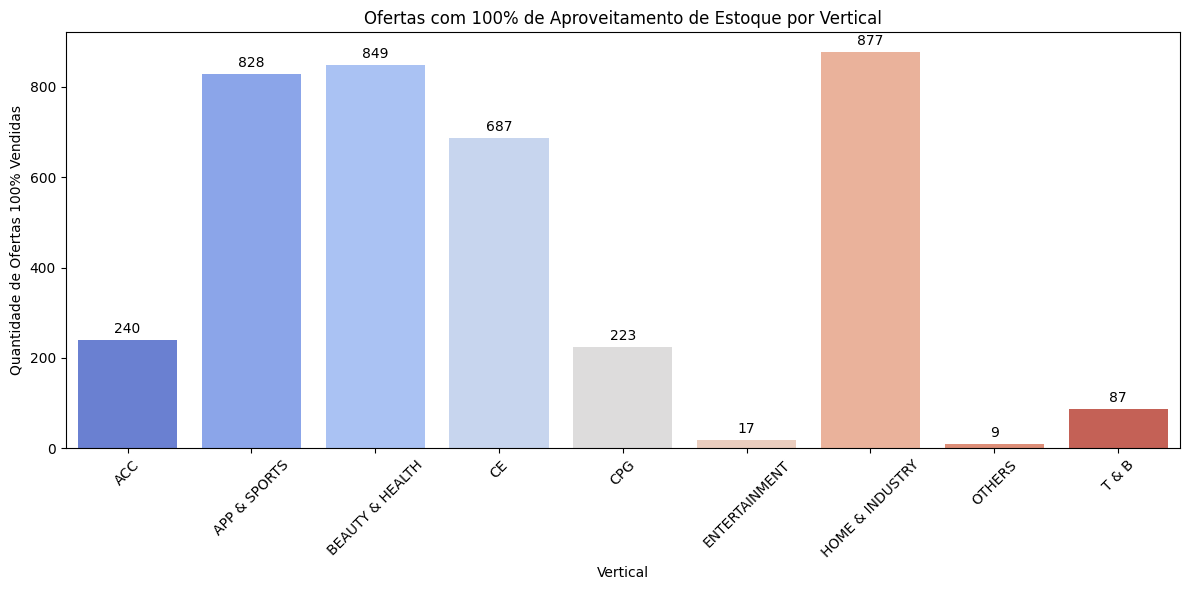

In [14]:
# -----------------------------
# Análise de ofertas com 100% de aproveitamento de estoque
# -----------------------------

# Filtrar promoções com aproveitamento de estoque igual a 100%
df['aproveitamento_individual'] = df['SOLD_QUANTITY'] / df['INVOLVED_STOCK']
df_100pct = df[df['aproveitamento_individual'] >= 1]

# Contagem por VERTICAL
metricas_100pct_vertical = df_100pct.groupby('VERTICAL').agg(
    ofertas_100pct=('VERTICAL', 'size'),
    receita_100pct=('SOLD_AMOUNT', 'sum')
).reset_index()

# Adicionar total geral para referência
total_100pct = df_100pct.shape[0]
total_receita_100pct = df_100pct['SOLD_AMOUNT'].sum()
print(f"Total de ofertas com 100% de aproveitamento: {total_100pct}")
print(f"Receita total gerada por essas ofertas: {total_receita_100pct:.2f}")
print("Distribuição por VERTICAL:")
display(metricas_100pct_vertical)

# Gráfico de barras
plt.figure(figsize=(12,6))
ax = sns.barplot(x='VERTICAL', y='ofertas_100pct', data=metricas_100pct_vertical, palette='coolwarm')
plt.title('Ofertas com 100% de Aproveitamento de Estoque por Vertical')
plt.ylabel('Quantidade de Ofertas 100% Vendidas')
plt.xlabel('Vertical')
plt.xticks(rotation=45)

# Adicionar rótulos nas barras
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0,3), textcoords='offset points')

plt.tight_layout()
plt.show()


Como o Frete Grátis se apresentou nessas ofertas?

Percentual de frete grátis entre todas as ofertas com 100% de aproveitamento: 32.41%
Presença de frete grátis entre ofertas com 100% de aproveitamento por VERTICAL:


/var/folders/rh/gjnf3wr53k74t6c597cx8_wm0000gn/T/ipykernel_57822/492160304.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_100pct.loc[:, 'frete_gratis'] = df_100pct['SHIPPING_PAYMENT_TYPE'] == 'free_shipping'


,VERTICAL,ofertas_100pct,frete_gratis_count,prop_frete_gratis
0,ACC,240,69,0.287500
1,APP & SPORTS,828,268,0.323671
2,BEAUTY & HEALTH,849,244,0.287397
3,CE,687,274,0.398836
4,CPG,223,57,0.255605
5,ENTERTAINMENT,17,9,0.529412
6,HOME & INDUSTRY,877,295,0.336374
7,OTHERS,9,2,0.222222
8,T & B,87,19,0.218391


/var/folders/rh/gjnf3wr53k74t6c597cx8_wm0000gn/T/ipykernel_57822/492160304.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='VERTICAL', y='prop_frete_gratis', data=frete_100pct_vertical, palette='YlGnBu')


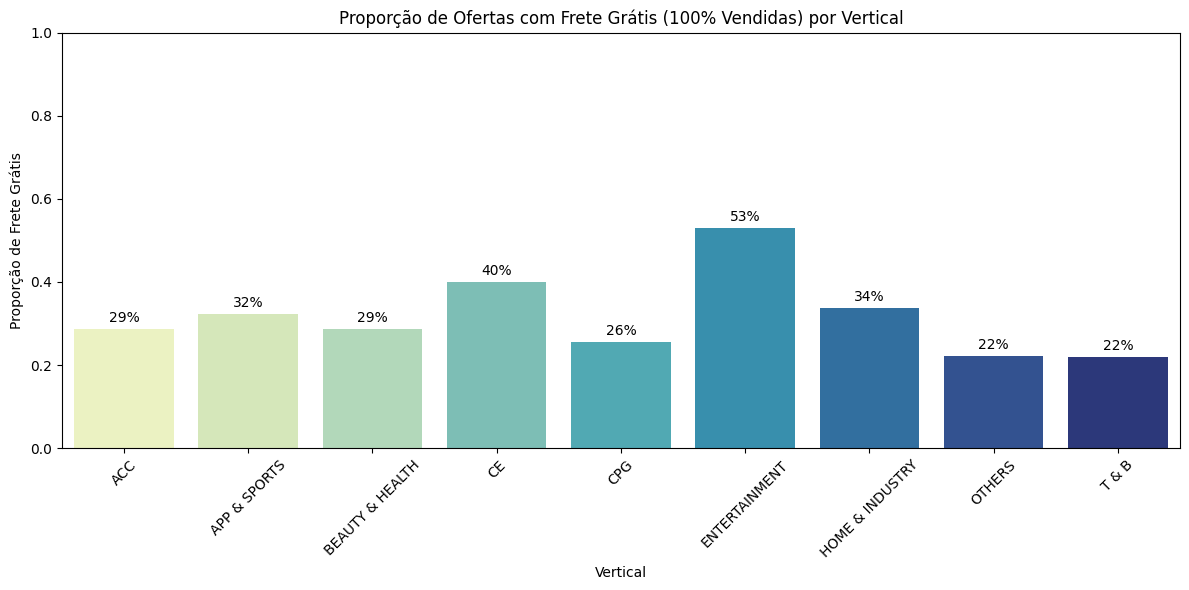

In [ ]:
# Criar flag para frete grátis baseado em SHIPPING_PAYMENT_TYPE
df_100pct.loc[:, 'frete_gratis'] = df_100pct['SHIPPING_PAYMENT_TYPE'] == 'free_shipping'

# Percentual geral de frete grátis
total_ofertas_100pct = df_100pct.shape[0]
total_frete_gratis = df_100pct['frete_gratis'].sum()
percentual_frete_gratis = total_frete_gratis / total_ofertas_100pct
print(f"Percentual de frete grátis entre todas as ofertas com 100% de aproveitamento: {percentual_frete_gratis:.2%}")

# Contagem e proporção de frete grátis por VERTICAL
frete_100pct_vertical = df_100pct.groupby('VERTICAL').agg(
    ofertas_100pct=('VERTICAL', 'size'),
    frete_gratis_count=('frete_gratis', 'sum')
).reset_index()
frete_100pct_vertical['prop_frete_gratis'] = frete_100pct_vertical['frete_gratis_count'] / frete_100pct_vertical['ofertas_100pct']

print("Presença de frete grátis entre ofertas com 100% de aproveitamento por VERTICAL:")
display(frete_100pct_vertical)

# Gráfico de barras com proporção de frete grátis
plt.figure(figsize=(12,6))
ax = sns.barplot(x='VERTICAL', y='prop_frete_gratis', data=frete_100pct_vertical, palette='YlGnBu')
plt.title('Proporção de Ofertas com Frete Grátis (100% Vendidas) por Vertical')
plt.ylabel('Proporção de Frete Grátis')
plt.xlabel('Vertical')
plt.ylim(0,1)
plt.xticks(rotation=45)

# Adicionar rótulos em porcentagem
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0%}', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0,3), textcoords='offset points')

plt.tight_layout()
plt.show()

O turno foi um fator determinante?

In [ ]:
# Garantir que a coluna TURNO exista no df_100pct

def get_turno(hora):
    if 6 <= hora < 12:
        return 'Manhã'
    elif 12 <= hora < 18:
        return 'Tarde'
    elif 18 <= hora < 24:
        return 'Noite'
    else:
        return 'Madrugada'
    
df_100pct.loc[:, 'TURNO'] = df_100pct['OFFER_START_DTTM'].dt.hour.apply(get_turno)

turno_percentual_100pct = df_100pct['TURNO'].value_counts(normalize=True).sort_index()
print("Percentual de ofertas por turno (100% aproveitadas):")
print(turno_percentual_100pct.to_frame(name='percentual'))


Percentual de ofertas por turno (100% aproveitadas):
       percentual
TURNO            
Manhã    0.218234
Noite    0.370186
Tarde    0.411580


/var/folders/rh/gjnf3wr53k74t6c597cx8_wm0000gn/T/ipykernel_57822/3347163027.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_100pct.loc[:, 'TURNO'] = df_100pct['OFFER_START_DTTM'].dt.hour.apply(get_turno)


/var/folders/rh/gjnf3wr53k74t6c597cx8_wm0000gn/T/ipykernel_57822/528271749.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x=turno_percentual_100pct.index, y=turno_percentual_100pct.values, palette='Pastel1')


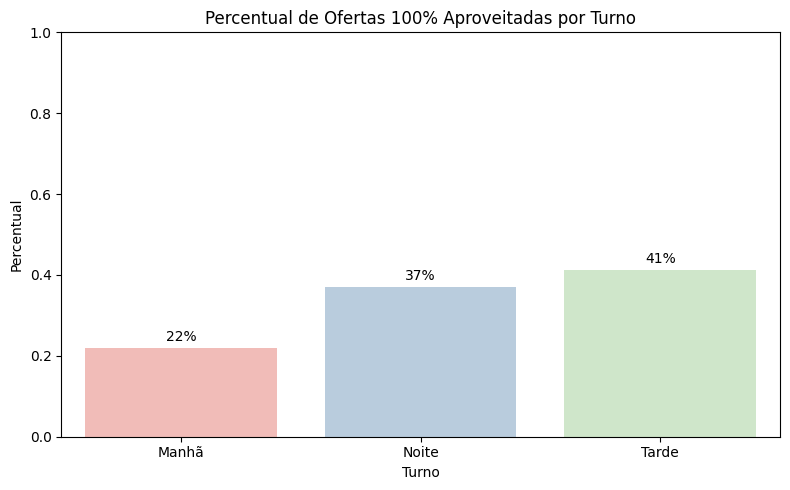

In [17]:
# Gráfico de barras para percentual de ofertas por turno
plt.figure(figsize=(8,5))
ax2 = sns.barplot(x=turno_percentual_100pct.index, y=turno_percentual_100pct.values, palette='Pastel1')
plt.title('Percentual de Ofertas 100% Aproveitadas por Turno')
plt.ylabel('Percentual')
plt.xlabel('Turno')
plt.ylim(0,1)

# Adicionar rótulos em porcentagem
for i, v in enumerate(turno_percentual_100pct.values):
    ax2.text(i, v + 0.01, f'{v:.0%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Visão Top Vendas e Receitas

Análise geral de vendas e receita por VERTICAL

In [ ]:

# Agrupar por VERTICAL, somando total de vendas e total de receita
tabela_vertical = df.groupby('VERTICAL').agg(
    total_vendas=('SOLD_QUANTITY', 'sum'),
    total_receita=('SOLD_AMOUNT', 'sum')
).reset_index()

# Ordenar pela quantidade de vendas decrescente
tabela_vertical = tabela_vertical.sort_values(by='total_vendas', ascending=False)

print("Resumo de vendas e receita por VERTICAL:")
display(tabela_vertical)


Resumo de vendas e receita por VERTICAL:


,VERTICAL,total_vendas,total_receita
2,BEAUTY & HEALTH,177396.0,547427.27
6,HOME & INDUSTRY,26530.0,155518.68
1,APP & SPORTS,25146.0,131101.36
3,CE,21608.0,362787.94
4,CPG,5475.0,16787.68
0,ACC,4981.0,26819.98
8,T & B,2204.0,14302.78
5,ENTERTAINMENT,357.0,1988.57
7,OTHERS,354.0,1929.24


In [19]:
# Ordenar o DataFrame original pela receita decrescente
top_receita_ofertas = df.sort_values(by='SOLD_AMOUNT', ascending=False)

print("Top receita por oferta individual:")
display(top_receita_ofertas)

Top receita por oferta individual:


,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID,VENDAS_CALCULADAS,DURACAO_HORAS,VALOR_UNITARIO,aproveitamento_individual
11449,2021-07-27,2021-07-27 09:00:00+00:00,2021-07-27 17:01:05+00:00,lightning_deal,2000,497,4836.57,1503.0,A,NaN,BEAUTY EQUIPMENT,BEAUTY & HEALTH,MLM-DISPOSABLE_GLOVES,1503,8.018056,3.217944,0.7515
37095,2021-06-18,2021-06-18 15:00:00+00:00,2021-06-18 23:00:00+00:00,lightning_deal,100,45,4678.68,75.0,A,free_shipping,MOBILE,CE,MLM-CELLPHONES,55,8.000000,62.382400,0.7500
13737,2021-07-19,2021-07-19 13:00:00+00:00,2021-07-19 21:00:55+00:00,lightning_deal,4000,2358,4570.31,1646.0,A,NaN,PHARMACEUTICS,BEAUTY & HEALTH,MLM-SURGICAL_AND_INDUSTRIAL_MASKS,1642,8.015278,2.776616,0.4115
45804,2021-07-26,2021-07-26 17:00:00+00:00,2021-07-27 01:00:05+00:00,lightning_deal,2000,1931,4264.51,67.0,A,free_shipping,MOBILE,CE,MLM-CELLPHONES,69,8.001389,63.649403,0.0335
13742,2021-07-19,2021-07-19 12:00:00+00:00,2021-07-19 20:00:00+00:00,lightning_deal,7000,5650,3988.84,1358.0,A,NaN,PHARMACEUTICS,BEAUTY & HEALTH,MLM-SURGICAL_AND_INDUSTRIAL_MASKS,1350,8.000000,2.937290,0.1940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48736,2021-06-19,2021-06-19 15:00:00+00:00,2021-06-19 23:00:00+00:00,lightning_deal,10,10,NaN,NaN,A,free_shipping,MOBILE,CE,MLM-TELEPHONES,0,8.000000,NaN,NaN
48738,2021-06-19,2021-06-19 15:00:00+00:00,2021-06-19 23:00:01+00:00,lightning_deal,10,10,NaN,NaN,A,free_shipping,MOBILE,CE,MLM-TELEPHONES,0,8.000278,NaN,NaN
48739,2021-06-19,2021-06-19 13:00:00+00:00,2021-06-19 21:00:00+00:00,lightning_deal,30,30,NaN,NaN,A,NaN,HOME&DECOR,HOME & INDUSTRY,MLM-MIRRORS,0,8.000000,NaN,NaN
48742,2021-06-19,2021-06-19 13:00:00+00:00,2021-06-19 19:00:01+00:00,lightning_deal,5,5,NaN,NaN,NaN,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-DECORATIVE_PAINTINGS,0,6.000278,NaN,NaN


## Análise de Relevância do Frete Grátis

Serão analisadas as influências do Frete Grátis numa visão geral e dentro de cada segmento. Serão utilizados testes de hipóteses estatísticos.

Visão geral:

In [45]:


# Criar coluna frete_gratis
df['frete_gratis'] = np.where(df['SHIPPING_PAYMENT_TYPE'] == "free_shipping", "Frete Grátis", "Sem Frete Grátis")

# Distribuição de promoções com frete grátis
total_promos = len(df)
total_frete_gratis = df[df['frete_gratis'] == "Frete Grátis"].shape[0]
percentual_frete_gratis = total_frete_gratis / total_promos
print(f"Promoções com frete grátis: {total_frete_gratis} de {total_promos} ({percentual_frete_gratis:.2%})")

# -----------------------------
# Testes de hipóteses: vendas, aproveitamento e receita
# -----------------------------

# Média de VENDAS
grupo_frete_vendas = df[df['frete_gratis'] == "Frete Grátis"]['VENDAS_CALCULADAS'].dropna()
grupo_sem_frete_vendas = df[df['frete_gratis'] == "Sem Frete Grátis"]['VENDAS_CALCULADAS'].dropna()

t_stat_vendas, p_val_vendas = stats.ttest_ind(grupo_frete_vendas, grupo_sem_frete_vendas, equal_var=False)
print(f"\nMédia de vendas calculadas:")
print(f"Frete Grátis: {grupo_frete_vendas.mean():.2f}")
print(f"Sem Frete Grátis: {grupo_sem_frete_vendas.mean():.2f}")
print(f"Teste T estatística: {t_stat_vendas:.3f}, p-valor: {p_val_vendas:.4f}")

# Aproveitamento de estoque (proporção de ofertas com 100% aproveitamento)
df['aproveitamento'] = df['VENDAS_CALCULADAS'] / df['INVOLVED_STOCK']
df['100pct_vendas'] = df['aproveitamento'] >= 1

aproveitamento_frete = df[df['frete_gratis'] == "Frete Grátis"]['100pct_vendas']
aproveitamento_sem_frete = df[df['frete_gratis'] == "Sem Frete Grátis"]['100pct_vendas']

# Teste de proporção
contingency_table = np.array([
    [aproveitamento_frete.sum(), (~aproveitamento_frete).sum()],
    [aproveitamento_sem_frete.sum(), (~aproveitamento_sem_frete).sum()]
])
chi2, p_val_aproveitamento, _, _ = stats.chi2_contingency(contingency_table)

print(f"\nAproveitamento 100% de estoque:")
print(f"Frete Grátis: {aproveitamento_frete.mean():.2%}")
print(f"Sem Frete Grátis: {aproveitamento_sem_frete.mean():.2%}")
print(f"Teste qui-quadrado p-valor: {p_val_aproveitamento:.4f}")

# Receita média
grupo_frete_receita = df[df['frete_gratis'] == "Frete Grátis"]['SOLD_AMOUNT'].dropna()
grupo_sem_frete_receita = df[df['frete_gratis'] == "Sem Frete Grátis"]['SOLD_AMOUNT'].dropna()

t_stat_receita, p_val_receita = stats.ttest_ind(grupo_frete_receita, grupo_sem_frete_receita, equal_var=False)
print(f"\nReceita média por oferta:")
print(f"Frete Grátis: {grupo_frete_receita.mean():.2f}")
print(f"Sem Frete Grátis: {grupo_sem_frete_receita.mean():.2f}")
print(f"Teste T estatística: {t_stat_receita:.3f}, p-valor: {p_val_receita:.4f}")


Promoções com frete grátis: 24409 de 44932 (54.32%)

Média de vendas calculadas:
Frete Grátis: 2.47
Sem Frete Grátis: 7.61
Teste T estatística: -20.086, p-valor: 0.0000

Aproveitamento 100% de estoque:
Frete Grátis: 6.49%
Sem Frete Grátis: 13.05%
Teste qui-quadrado p-valor: 0.0000

Receita média por oferta:
Frete Grátis: 63.79
Sem Frete Grátis: 39.71
Teste T estatística: 10.691, p-valor: 0.0000


In [46]:

# Análise de frete grátis e teste de hipóteses por VERTICAL


# Criar coluna frete_gratis
df['frete_gratis'] = np.where(
    df['SHIPPING_PAYMENT_TYPE'] == "free_shipping",
    "Frete Grátis",
    "Sem Frete Grátis"
)

# Obter lista de verticais únicas
verticais = df['VERTICAL'].dropna().unique()

for v in verticais:
    print(f"\n--- VERTICAL: {v} ---")
    df_v = df[df['VERTICAL'] == v]

    # Quantidade de promoções e percentual com frete grátis
    total_promos = len(df_v)
    total_frete_gratis = df_v[df_v['frete_gratis'] == "Frete Grátis"].shape[0]
    percentual_frete_gratis = total_frete_gratis / total_promos
    print(f"Promoções com frete grátis: {total_frete_gratis} de {total_promos} ({percentual_frete_gratis:.2%})")
    
    # -------------------------
    # Média de VENDAS
    # -------------------------
    grupo_frete_vendas = df_v[df_v['frete_gratis'] == "Frete Grátis"]['VENDAS_CALCULADAS'].dropna()
    grupo_sem_frete_vendas = df_v[df_v['frete_gratis'] == "Sem Frete Grátis"]['VENDAS_CALCULADAS'].dropna()

    if len(grupo_frete_vendas) > 1 and len(grupo_sem_frete_vendas) > 1:
        t_stat_vendas, p_val_vendas = stats.ttest_ind(
            grupo_frete_vendas, grupo_sem_frete_vendas, equal_var=False
        )
        print(f"Média de vendas calculadas - Frete Grátis: {grupo_frete_vendas.mean():.2f}, "
              f"Sem Frete Grátis: {grupo_sem_frete_vendas.mean():.2f}, "
              f"t-valor: {t_stat_vendas:.3f}, p-valor: {p_val_vendas:.4f}")
    else:
        print("Dados insuficientes para teste de vendas")
    
    # -------------------------
    # Aproveitamento de estoque
    # -------------------------
    df_v['aproveitamento'] = df_v['VENDAS_CALCULADAS'] / df_v['INVOLVED_STOCK']
    df_v['100pct_vendas'] = df_v['aproveitamento'] >= 1

    aproveitamento_frete = df_v[df_v['frete_gratis'] == "Frete Grátis"]['100pct_vendas']
    aproveitamento_sem_frete = df_v[df_v['frete_gratis'] == "Sem Frete Grátis"]['100pct_vendas']
    
    if len(aproveitamento_frete) > 0 and len(aproveitamento_sem_frete) > 0:
        contingency_table = np.array([
            [aproveitamento_frete.sum(), (~aproveitamento_frete).sum()],
            [aproveitamento_sem_frete.sum(), (~aproveitamento_sem_frete).sum()]
        ])
        chi2, p_val_aproveitamento, _, _ = stats.chi2_contingency(contingency_table)
        print(f"Aproveitamento 100% - Frete Grátis: {aproveitamento_frete.mean():.2%}, "
              f"Sem Frete Grátis: {aproveitamento_sem_frete.mean():.2%}, "
              f"p-valor: {p_val_aproveitamento:.4f}")
    else:
        print("Dados insuficientes para teste de aproveitamento")
    
    # -------------------------
    # Receita média
    # -------------------------
    grupo_frete_receita = df_v[df_v['frete_gratis'] == "Frete Grátis"]['SOLD_AMOUNT'].dropna()
    grupo_sem_frete_receita = df_v[df_v['frete_gratis'] == "Sem Frete Grátis"]['SOLD_AMOUNT'].dropna()

    if len(grupo_frete_receita) > 1 and len(grupo_sem_frete_receita) > 1:
        t_stat_receita, p_val_receita = stats.ttest_ind(
            grupo_frete_receita, grupo_sem_frete_receita, equal_var=False
        )
        print(f"Receita média - Frete Grátis: {grupo_frete_receita.mean():.2f}, "
              f"Sem Frete Grátis: {grupo_sem_frete_receita.mean():.2f}, "
              f"t-valor: {t_stat_receita:.3f}, p-valor: {p_val_receita:.4f}")
    else:
        print("Dados insuficientes para teste de receita")




--- VERTICAL: CPG ---
Promoções com frete grátis: 1092 de 2455 (44.48%)
Média de vendas calculadas - Frete Grátis: 1.38, Sem Frete Grátis: 3.28, t-valor: -9.272, p-valor: 0.0000
Aproveitamento 100% - Frete Grátis: 6.59%, Sem Frete Grátis: 12.69%, p-valor: 0.0000
Receita média - Frete Grátis: 20.36, Sem Frete Grátis: 9.62, t-valor: 9.193, p-valor: 0.0000

--- VERTICAL: OTHERS ---
Promoções com frete grátis: 153 de 240 (63.75%)
Média de vendas calculadas - Frete Grátis: 1.01, Sem Frete Grátis: 2.28, t-valor: -3.122, p-valor: 0.0023
Aproveitamento 100% - Frete Grátis: 2.61%, Sem Frete Grátis: 8.05%, p-valor: 0.1067
Receita média - Frete Grátis: 20.10, Sem Frete Grátis: 11.21, t-valor: 3.252, p-valor: 0.0015

--- VERTICAL: CE ---
Promoções com frete grátis: 4831 de 7850 (61.54%)
Média de vendas calculadas - Frete Grátis: 2.92, Sem Frete Grátis: 3.88, t-valor: -6.438, p-valor: 0.0000
Aproveitamento 100% - Frete Grátis: 9.07%, Sem Frete Grátis: 15.83%, p-valor: 0.0000
Receita média - Frete 

/var/folders/rh/gjnf3wr53k74t6c597cx8_wm0000gn/T/ipykernel_57822/1644158358.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v['aproveitamento'] = df_v['VENDAS_CALCULADAS'] / df_v['INVOLVED_STOCK']
/var/folders/rh/gjnf3wr53k74t6c597cx8_wm0000gn/T/ipykernel_57822/1644158358.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v['100pct_vendas'] = df_v['aproveitamento'] >= 1


Testes de relevância para vendas de itens mais caros:

In [47]:
# -----------------------------
# Análise de frete grátis para promoções com valor do item > 6, por VERTICAL
# -----------------------------
# Filtrar promoções com duração >= 1 minuto e valor do item > 6
df_filtered = df[(df['VALOR_UNITARIO'] > 6)].copy()

# Criar coluna frete_gratis
df_filtered['frete_gratis'] = np.where(df_filtered['SHIPPING_PAYMENT_TYPE'] == "free_shipping", "Frete Grátis", "Sem Frete Grátis")

# Estatísticas gerais
total_promos = len(df_filtered)
total_frete_gratis = df_filtered[df_filtered['frete_gratis'] == "Frete Grátis"].shape[0]
percentual_frete_gratis = total_frete_gratis / total_promos
print(f"Promoções com frete grátis: {total_frete_gratis} de {total_promos} ({percentual_frete_gratis:.2%})")

# Média de VENDAS
grupo_frete_vendas = df_filtered[df_filtered['frete_gratis'] == "Frete Grátis"]['VENDAS_CALCULADAS'].dropna()
grupo_sem_frete_vendas = df_filtered[df_filtered['frete_gratis'] == "Sem Frete Grátis"]['VENDAS_CALCULADAS'].dropna()
if len(grupo_frete_vendas) > 1 and len(grupo_sem_frete_vendas) > 1:
    t_stat_vendas, p_val_vendas = stats.ttest_ind(grupo_frete_vendas, grupo_sem_frete_vendas, equal_var=False)
    print(f"Média de vendas calculadas - Frete Grátis: {grupo_frete_vendas.mean():.2f}, Sem Frete Grátis: {grupo_sem_frete_vendas.mean():.2f}, t-valor: {t_stat_vendas:.3f}, p-valor: {p_val_vendas:.4f}")
else:
    print("Dados insuficientes para teste de vendas")

# Aproveitamento de estoque
df_filtered['aproveitamento'] = df_filtered['VENDAS_CALCULADAS'] / df_filtered['INVOLVED_STOCK']
df_filtered['100pct_vendas'] = df_filtered['aproveitamento'] >= 1
aproveitamento_frete = df_filtered[df_filtered['frete_gratis'] == "Frete Grátis"]['100pct_vendas']
aproveitamento_sem_frete = df_filtered[df_filtered['frete_gratis'] == "Sem Frete Grátis"]['100pct_vendas']
if len(aproveitamento_frete) > 0 and len(aproveitamento_sem_frete) > 0:
    contingency_table = np.array([
        [aproveitamento_frete.sum(), (~aproveitamento_frete).sum()],
        [aproveitamento_sem_frete.sum(), (~aproveitamento_sem_frete).sum()]
    ])
    chi2, p_val_aproveitamento, _, _ = stats.chi2_contingency(contingency_table)
    print(f"Aproveitamento 100% - Frete Grátis: {aproveitamento_frete.mean():.2%}, Sem Frete Grátis: {aproveitamento_sem_frete.mean():.2%}, p-valor: {p_val_aproveitamento:.4f}")
else:
    print("Dados insuficientes para teste de aproveitamento")

# Receita média
grupo_frete_receita = df_filtered[df_filtered['frete_gratis'] == "Frete Grátis"]['SOLD_AMOUNT'].dropna()
grupo_sem_frete_receita = df_filtered[df_filtered['frete_gratis'] == "Sem Frete Grátis"]['SOLD_AMOUNT'].dropna()
if len(grupo_frete_receita) > 1 and len(grupo_sem_frete_receita) > 1:
    t_stat_receita, p_val_receita = stats.ttest_ind(grupo_frete_receita, grupo_sem_frete_receita, equal_var=False)
    print(f"Receita média - Frete Grátis: {grupo_frete_receita.mean():.2f}, Sem Frete Grátis: {grupo_sem_frete_receita.mean():.2f}, t-valor: {t_stat_receita:.3f}, p-valor: {p_val_receita:.4f}")
else:
    print("Dados insuficientes para teste de receita")


Promoções com frete grátis: 8219 de 8296 (99.07%)
Média de vendas calculadas - Frete Grátis: 3.91, Sem Frete Grátis: 3.35, t-valor: 1.024, p-valor: 0.3090
Aproveitamento 100% - Frete Grátis: 11.49%, Sem Frete Grátis: 6.49%, p-valor: 0.2340
Receita média - Frete Grátis: 74.71, Sem Frete Grátis: 56.15, t-valor: 0.994, p-valor: 0.3234


### IMPACTO DO PERÍODO DA OFERTA

O objetivo será entender em como as ofertas são apresentadas durante a semana e em diferentes horários, avaliando seus desempenhos.

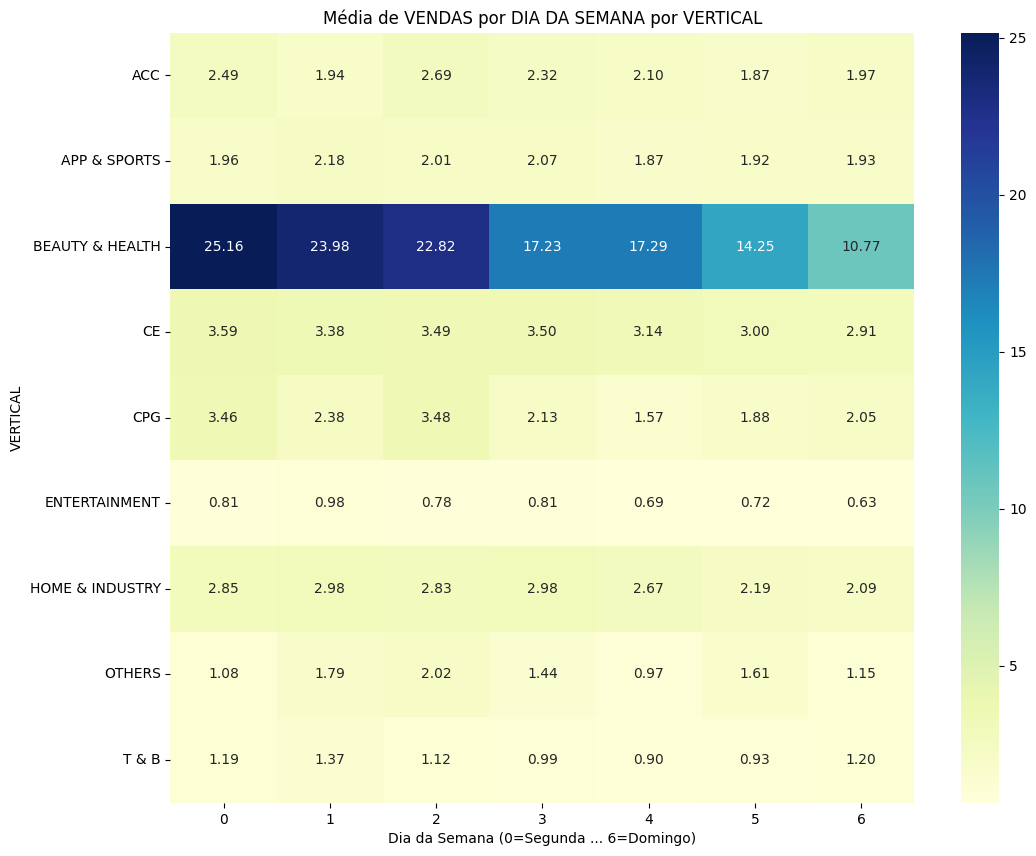

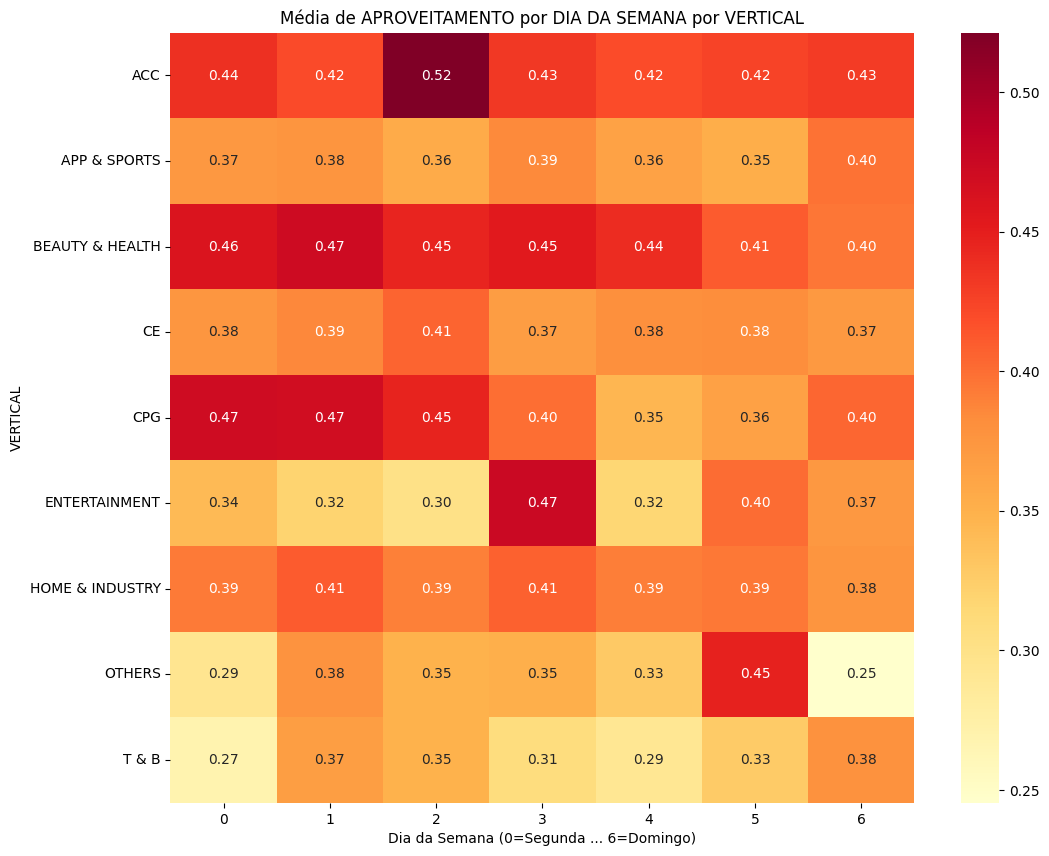

In [48]:
# -----------------------------
# Gráficos de VENDAS e APROVEITAMENTO a nível de VERTICAL
# -----------------------------
import matplotlib.pyplot as plt
import seaborn as sns


# Calcular métricas médias por VERTICAL e DIA_DA_SEMANA
metrics_vertical_dia = df.groupby(['VERTICAL', 'DIA_DA_SEMANA']).agg(
    media_vendas=('VENDAS_CALCULADAS', 'mean'),
    media_aproveitamento=('aproveitamento_individual', 'mean')
).reset_index()

# Pivotar para heatmap - Vendas
heatmap_vendas = metrics_vertical_dia.pivot(index='VERTICAL', columns='DIA_DA_SEMANA', values='media_vendas').fillna(0)
plt.figure(figsize=(12,10))
sns.heatmap(heatmap_vendas, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Média de VENDAS por DIA DA SEMANA por VERTICAL')
plt.ylabel('VERTICAL')
plt.xlabel('Dia da Semana (0=Segunda ... 6=Domingo)')
plt.show()

# Pivotar para heatmap - Aproveitamento
heatmap_aproveitamento = metrics_vertical_dia.pivot(index='VERTICAL', columns='DIA_DA_SEMANA', values='media_aproveitamento').fillna(0)
plt.figure(figsize=(12,10))
sns.heatmap(heatmap_aproveitamento, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Média de APROVEITAMENTO por DIA DA SEMANA por VERTICAL')
plt.ylabel('VERTICAL')
plt.xlabel('Dia da Semana (0=Segunda ... 6=Domingo)')
plt.show()


/var/folders/rh/gjnf3wr53k74t6c597cx8_wm0000gn/T/ipykernel_57822/404038754.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='TURNO', y='aproveitamento_individual', ax=axs[0], palette='Greens')
/var/folders/rh/gjnf3wr53k74t6c597cx8_wm0000gn/T/ipykernel_57822/404038754.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='DIA_DA_SEMANA', y='aproveitamento_individual', ax=axs[1], palette='Oranges')
/var/folders/rh/gjnf3wr53k74t6c597cx8_wm0000gn/T/ipykernel_57822/404038754.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['Seg','Ter','Qua','Qui','Sex','Sáb','Dom

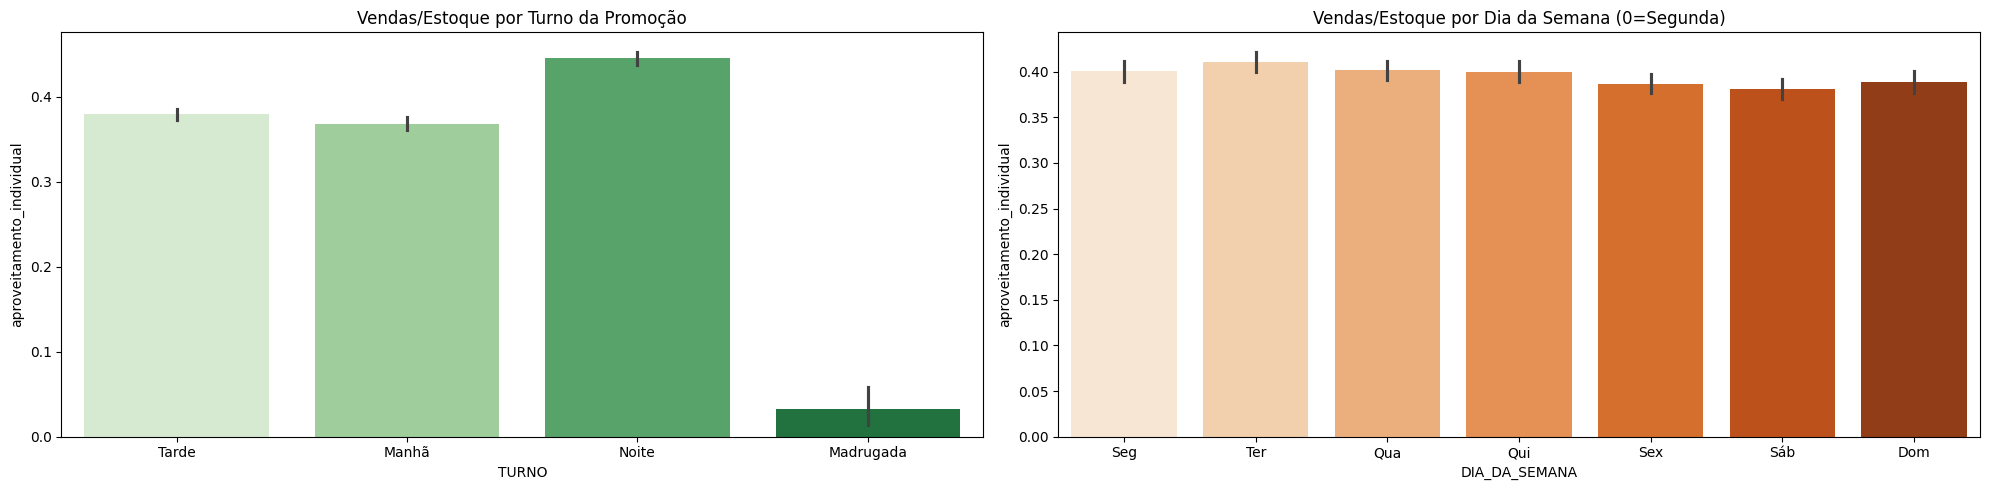

In [31]:

# Médias da métrica por categoria
fig, axs = plt.subplots(1,2, figsize=(20,5))

sns.barplot(data=df, x='TURNO', y='aproveitamento_individual', ax=axs[0], palette='Greens')
axs[0].set_title('Vendas/Estoque por Turno da Promoção')

sns.barplot(data=df, x='DIA_DA_SEMANA', y='aproveitamento_individual', ax=axs[1], palette='Oranges')
axs[1].set_title('Vendas/Estoque por Dia da Semana (0=Segunda)')
axs[1].set_xticklabels(['Seg','Ter','Qua','Qui','Sex','Sáb','Dom'])

plt.tight_layout()
plt.show()

Serão aplicados alguns testes de hipóteses para poder afirmar se existe ou não diferenças estatísticamente significantes. Foram aplicados tanto testes de hipóteses paramétricos como não paramétricos, dada a natureza dos dados apresentados.

In [35]:
turnos = df['TURNO'].dropna().unique()
grupos_turno = [df.loc[df['TURNO'] == t, 'aproveitamento_individual'].dropna() for t in turnos]

anova_stat, anova_p = f_oneway(*grupos_turno)
print(f"ANOVA - Turno: estatística={anova_stat:.3f}, p-valor={anova_p:.4f}")

kruskal_stat, kruskal_p = kruskal(*grupos_turno)
print(f"Kruskal-Wallis - Turno: estatística={kruskal_stat:.3f}, p-valor={kruskal_p:.4f}")

ANOVA - Turno: estatística=86.805, p-valor=0.0000
Kruskal-Wallis - Turno: estatística=393.196, p-valor=0.0000


In [37]:
dias = range(7)
grupos_dia = [df.loc[df['DIA_DA_SEMANA'] == d, 'aproveitamento_individual'].dropna() for d in dias]

anova_stat, anova_p = f_oneway(*grupos_dia)
print(f"ANOVA - Dia da Semana: estatística={anova_stat:.3f}, p-valor={anova_p:.4f}")

kruskal_stat, kruskal_p = kruskal(*grupos_dia)
print(f"Kruskal-Wallis - Dia da Semana: estatística={kruskal_stat:.3f}, p-valor={kruskal_p:.4f}")


ANOVA - Dia da Semana: estatística=3.428, p-valor=0.0022
Kruskal-Wallis - Dia da Semana: estatística=11.756, p-valor=0.0676


Após avaliar num contexto de grupos com o testes Anova e Kruskal-Wallis, serão avaliados as diferenças dois a dois através do teste de comparação de tukey.

In [ ]:


def tukey_posthoc(df, valor_col, grupo_col):
    # Remover NaNs
    df_filtrado = df[[valor_col, grupo_col]].dropna()
    
    tukey = pairwise_tukeyhsd(endog=df_filtrado[valor_col],
                              groups=df_filtrado[grupo_col],
                              alpha=0.05)
    
    print(f"Comparações múltiplas para {grupo_col}:")
    print(tukey.summary())
    
    # Construir matriz de p-valores
    res = tukey._results_table.data[1:]  # Ignora cabeçalho
    
    grupos = sorted(df_filtrado[grupo_col].unique())
    matriz_p = pd.DataFrame(np.ones((len(grupos), len(grupos))), index=grupos, columns=grupos)
    
    for linha in res:
        g1, g2, meandiff, p_adj, lower, upper, reject = linha
        matriz_p.loc[g1, g2] = p_adj
        matriz_p.loc[g2, g1] = p_adj
    
    print("\nMatriz de p-valores (duas casas decimais):")
    display(matriz_p.round(3))
    print("\n")

# Aplicar para cada variável:

tukey_posthoc(df, 'aproveitamento_individual', 'TURNO')
tukey_posthoc(df, 'aproveitamento_individual', 'DIA_DA_SEMANA')


Comparações múltiplas para TURNO:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
  group1  group2 meandiff p-adj  lower   upper  reject
------------------------------------------------------
Madrugada  Manhã   0.3351   0.0  0.1729  0.4974   True
Madrugada  Noite   0.4125   0.0  0.2502  0.5747   True
Madrugada  Tarde   0.3462   0.0  0.1841  0.5084   True
    Manhã  Noite   0.0773   0.0  0.0624  0.0922   True
    Manhã  Tarde   0.0111 0.163 -0.0027  0.0249  False
    Noite  Tarde  -0.0662   0.0 -0.0793 -0.0531   True
------------------------------------------------------

Matriz de p-valores (duas casas decimais):


,Madrugada,Manhã,Noite,Tarde
Madrugada,1.0,0.000,0.0,0.000
Manhã,0.0,1.000,0.0,0.163
Noite,0.0,0.000,1.0,0.000
Tarde,0.0,0.163,0.0,1.000




Comparações múltiplas para DIA_DA_SEMANA:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   0.0108 0.8391 -0.0132  0.0348  False
     0      2   0.0012    1.0  -0.023  0.0254  False
     0      3  -0.0003    1.0 -0.0242  0.0236  False
     0      4  -0.0139 0.6015 -0.0378  0.0099  False
     0      5  -0.0195 0.2134 -0.0439  0.0048  False
     0      6  -0.0114 0.8458 -0.0371  0.0142  False
     1      2  -0.0096 0.8905 -0.0331  0.0139  False
     1      3  -0.0111 0.7954 -0.0343  0.0121  False
     1      4  -0.0247 0.0272 -0.0479 -0.0016   True
     1      5  -0.0304  0.003  -0.054 -0.0067   True
     1      6  -0.0223 0.1194 -0.0473  0.0028  False
     2      3  -0.0015    1.0 -0.0249  0.0219  False
     2      4  -0.0151 0.4743 -0.0384  0.0082  False
     2      5  -0.0207 0.1379 -0.0446  0.0031  False
     2      6  -0.0126 0.7589 -0.0378  0.0126  False
  

,0,1,2,3,4,5,6
0,1.000,0.839,1.000,1.000,0.602,0.213,0.846
1,0.839,1.000,0.890,0.795,0.027,0.003,0.119
2,1.000,0.890,1.000,1.000,0.474,0.138,0.759
3,1.000,0.795,1.000,1.000,0.587,0.196,0.844
4,0.602,0.027,0.474,0.587,1.000,0.992,1.000
5,0.213,0.003,0.138,0.196,0.992,1.000,0.966
6,0.846,0.119,0.759,0.844,1.000,0.966,1.000


Contagem de promoções por VERTICAL e Dia da Semana:


DIA_DA_SEMANA,0,1,2,3,4,5,6
VERTICAL,,,,,,,
ACC,340,368,304,352,364,316,314
APP & SPORTS,1493,1694,1698,1814,2069,1987,1567
BEAUTY & HEALTH,915,982,920,981,1100,901,753
CE,982,1172,1147,1196,1204,1237,912
CPG,328,481,360,355,309,385,237
ENTERTAINMENT,69,43,83,72,65,85,62
HOME & INDUSTRY,1326,1553,1351,1489,1654,1595,1282
OTHERS,38,42,42,25,34,33,26
T & B,304,362,355,466,366,342,231


Contagem de promoções por VERTICAL e Turno:


TURNO,Madrugada,Manhã,Noite,Tarde
VERTICAL,,,,
ACC,1,781,719,857
APP & SPORTS,0,3955,3480,4887
BEAUTY & HEALTH,0,1898,1600,3054
CE,62,2188,2165,3435
CPG,0,539,700,1216
ENTERTAINMENT,0,124,138,217
HOME & INDUSTRY,7,3019,2745,4479
OTHERS,0,59,53,128
T & B,0,632,558,1236


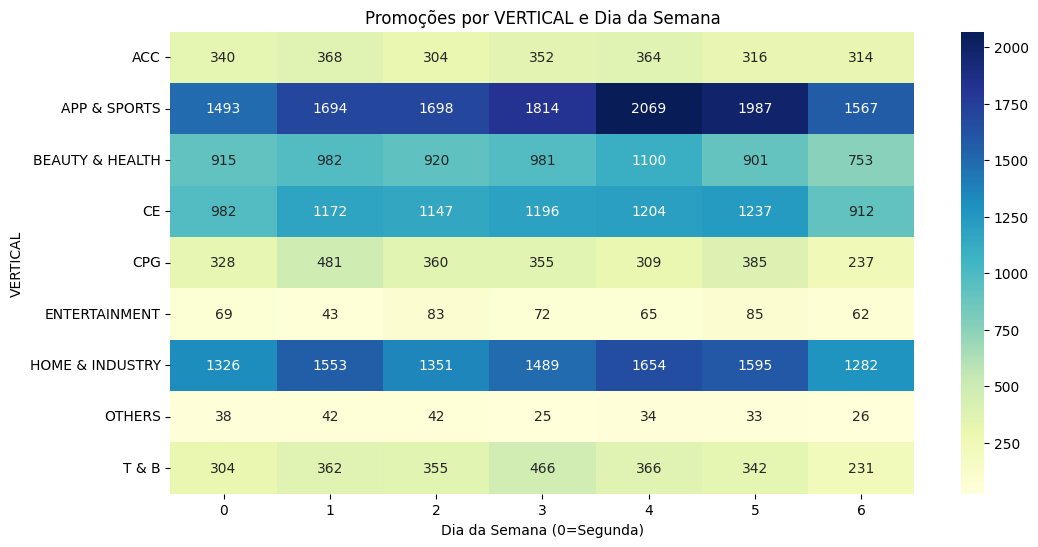

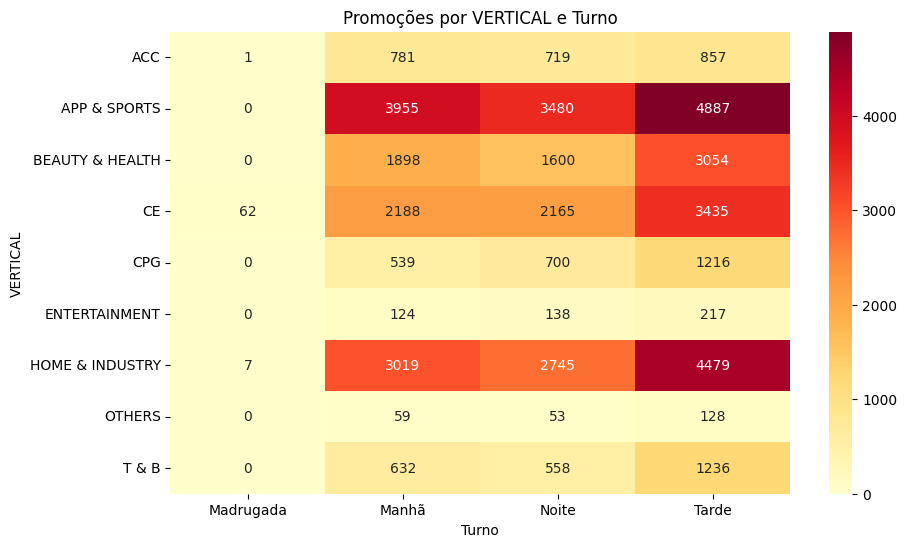

In [39]:
# Criar tabelas de contagem
contagem_dia_vertical = pd.crosstab(df['VERTICAL'], df['DIA_DA_SEMANA'])
contagem_turno_vertical = pd.crosstab(df['VERTICAL'], df['TURNO'])

print("Contagem de promoções por VERTICAL e Dia da Semana:")
display(contagem_dia_vertical)

print("Contagem de promoções por VERTICAL e Turno:")
display(contagem_turno_vertical)

# Opcional: Gráfico heatmap para visualizar concentração

plt.figure(figsize=(12,6))
sns.heatmap(contagem_dia_vertical, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Promoções por VERTICAL e Dia da Semana')
plt.xlabel('Dia da Semana (0=Segunda)')
plt.ylabel('VERTICAL')
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(contagem_turno_vertical, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Promoções por VERTICAL e Turno')
plt.xlabel('Turno')
plt.ylabel('VERTICAL')
plt.show()

## Cálculo de estimativa de receita final

Como não sabíamos exatamente a receita de 1.1% das ofertas, resolveu-se realizar uma estimativa quanto a essas ofertas. Utilizou-se um Intervalo de confiança de 95% através das médias por Dominio_ID.

In [44]:

import numpy as np
import pandas as pd
from scipy import stats

# =========================
# 1. Visão geral
# =========================
visao_geral = pd.DataFrame({
    'ofertas_realizadas': [len(df)], 
    'total_vendas': [df['SOLD_QUANTITY'].sum()],
    'total_receita': [df['SOLD_AMOUNT'].sum()],
    'total_estoque': [df['INVOLVED_STOCK'].sum()]
})

visao_geral['aproveitamento_estoque'] = (
    visao_geral['total_vendas'] / visao_geral['total_estoque']
)

print("\n📊 Visão geral:")
display(visao_geral)

# =========================
# 2. Estimativa para promoções sem SOLD_AMOUNT mas com vendas > 0
# =========================

# 2.1 Calcular preço médio por item usando dados completos
df_precos = df[df['SOLD_AMOUNT'].notna()].copy()
df_precos['PRECO_MEDIO_ITEM'] = (
    df_precos['SOLD_AMOUNT'] / 
    (df_precos['INVOLVED_STOCK'] - df_precos['REMAINING_STOCK_AFTER_END'])
)

# Remover valores inválidos
df_precos = df_precos.replace([np.inf, -np.inf], np.nan)
df_precos = df_precos.dropna(subset=['PRECO_MEDIO_ITEM'])

# Função para IC 95%
def ic_95(series):
    n = len(series)
    mean = series.mean()
    if n > 1:
        sem = stats.sem(series)
        h = sem * stats.t.ppf(0.975, n - 1)
    else:
        h = 0
    return mean, mean - h, mean + h

# Média e IC95 por categoria
precos_agg = (
    df_precos.groupby('DOM_DOMAIN_AGG1')['PRECO_MEDIO_ITEM']
    .apply(lambda x: ic_95(x))
    .apply(pd.Series)
)
precos_agg.columns = ['mean', 'lower_ci95', 'upper_ci95']

print("\n💰 Preço médio por item e IC95 por DOM_DOMAIN_AGG1:")
display(precos_agg)

# 2.2 Aplicar estimativa para casos sem SOLD_AMOUNT mas com vendas > 0
df_sem_valor = df[
    df['SOLD_AMOUNT'].isna() &
    ((df['INVOLVED_STOCK'] - df['REMAINING_STOCK_AFTER_END']) > 0)
].copy()

df_sem_valor['VENDAS_CALCULADAS'] = (
    df_sem_valor['INVOLVED_STOCK'] - df_sem_valor['REMAINING_STOCK_AFTER_END']
)

# Mapear preços estimados
df_sem_valor = df_sem_valor.merge(
    precos_agg,
    left_on='DOM_DOMAIN_AGG1',
    right_index=True,
    how='left'
)

# Estimar receita para três cenários
df_sem_valor['ESTIMATIVA_PESSIMISTA'] = (
    df_sem_valor['VENDAS_CALCULADAS'] * df_sem_valor['lower_ci95']
)
df_sem_valor['ESTIMATIVA_NORMAL'] = (
    df_sem_valor['VENDAS_CALCULADAS'] * df_sem_valor['mean']
)
df_sem_valor['ESTIMATIVA_OTIMISTA'] = (
    df_sem_valor['VENDAS_CALCULADAS'] * df_sem_valor['upper_ci95']
)

# =========================
# 3. Receita estimada e total
# =========================
receita_est_pessimista = df_sem_valor['ESTIMATIVA_PESSIMISTA'].sum()
receita_est_normal = df_sem_valor['ESTIMATIVA_NORMAL'].sum()
receita_est_otimista = df_sem_valor['ESTIMATIVA_OTIMISTA'].sum()

print("\n📈 Receita estimada para promoções sem SOLD_AMOUNT (vendas > 0):")
print(f"Pessimista (IC95-): R$ {receita_est_pessimista:,.2f}")
print(f"Normal (média):    R$ {receita_est_normal:,.2f}")
print(f"Otimista (IC95+):  R$ {receita_est_otimista:,.2f}")

# Receita real conhecida
receita_real = visao_geral['total_receita'].sum(skipna=True)

# Receita total
receita_total_pessimista = receita_real + receita_est_pessimista
receita_total_normal = receita_real + receita_est_normal
receita_total_otimista = receita_real + receita_est_otimista

print("\n💵 Receita total estimada com preenchimento dos valores ausentes:")
print(f"Pessimista: R$ {receita_total_pessimista:,.2f}")
print(f"Normal:     R$ {receita_total_normal:,.2f}")
print(f"Otimista:   R$ {receita_total_otimista:,.2f}")



📊 Visão geral:


,ofertas_realizadas,total_vendas,total_receita,total_estoque,aproveitamento_estoque
0,44932,264051.0,1258663.5,1641073,0.160901



💰 Preço médio por item e IC95 por DOM_DOMAIN_AGG1:


,mean,lower_ci95,upper_ci95
DOM_DOMAIN_AGG1,,,
ACC TOOLS,7.475082,5.572660,9.377503
ANTIQUES & HOBBIES,15.678333,-27.792313,59.148980
APPAREL,5.409468,5.265257,5.553679
APPAREL ACCESORIES,5.575615,5.255475,5.895754
AUTOPARTS,5.204474,4.879999,5.528948
BABY,10.623121,8.562330,12.683912
BATTERIES,2.098428,1.705796,2.491060
BEAUTY EQUIPMENT,8.220556,7.510968,8.930144
"BOOKS, MULTIMEDIA & OTHER E!",5.399508,4.721355,6.077661



📈 Receita estimada para promoções sem SOLD_AMOUNT (vendas > 0):
Pessimista (IC95-): R$ 36,688.33
Normal (média):    R$ 41,909.41
Otimista (IC95+):  R$ 47,130.49

💵 Receita total estimada com preenchimento dos valores ausentes:
Pessimista: R$ 1,295,351.83
Normal:     R$ 1,300,572.91
Otimista:   R$ 1,305,793.99
